# Prediction of Maintenance for Aircraft Engine

This notebook presents an end-to-end workflow to predict the **Remaining Useful Life (RUL)** of aircraft engines using sensor data. We will process the dataset, engineer features, and build regression models to estimate RUL.

### Course: ME228 — Final Project  
### Title: Prediction of Maintenance for Aircraft Engine  
### Team: Shivendararaj Godbole
### Student ID: 24M0051
### Data Sources:
- https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data
- https://www.kaggle.com/datasets/vamshikreddy/pm-dataset

### Source code: Developed by Shivendraraj Godbole
### Objective:
- Monitor engine health
- Predict Remaining Useful Life (RUL) of aircraft engines
- Provide necessary maintenance



In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import zipfile
import os
from google.colab import files

In [ ]:
# Check available files
print("Available files:", os.listdir())

# Upload dataset if missing
zip_path = "archive.zip"
extract_folder = "dataset"
if zip_path not in os.listdir():
    print("Please upload the dataset file: archive.zip")
    uploaded = files.upload()

# Ensure file is now present
if zip_path not in os.listdir():
    raise FileNotFoundError(f"{zip_path} not found. Please upload the correct dataset file.")

# Extract uploaded dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Verify extracted files
extracted_files = os.listdir(extract_folder)
print("Extracted Files:", extracted_files)

# Check if files are inside a subfolder
subfolders = [f for f in extracted_files if os.path.isdir(os.path.join(extract_folder, f))]
if subfolders:
    print("Detected subfolder, updating file paths...")
    extract_folder = os.path.join(extract_folder, subfolders[0])
    print("New dataset path:", extract_folder)

Available files: ['.config', 'extracted_files', 'linear_regression_model.pkl', 'dataset', 'archive.zip', 'random_forest_model.pkl', 'sample_data']
Extracted Files: ['archive']
Detected subfolder, updating file paths...
New dataset path: dataset/archive


In [ ]:
# Load datasets from text files
def load_txt_data(file_path):
    """Loads space-delimited text data into a pandas DataFrame."""
    column_names = ["unit", "time", "operational_setting_1", "operational_setting_2", "operational_setting_3",
                    "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5", "sensor_6", "sensor_7", "sensor_8",
                    "sensor_9", "sensor_10", "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15",
                    "sensor_16", "sensor_17", "sensor_18", "sensor_19", "sensor_20", "sensor_21"]
    return pd.read_csv(file_path, delim_whitespace=True, names=column_names)

# Update file paths based on extracted files
train_file_path = os.path.join(extract_folder, "train_FD001.txt")
test_file_path = os.path.join(extract_folder, "test_FD001.txt")
rul_file_path = os.path.join(extract_folder, "RUL_FD001.txt")

# Check if files exist before loading
def check_file_exists(file_path):
    """Checks if the specified file exists."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

check_file_exists(train_file_path)
check_file_exists(test_file_path)
check_file_exists(rul_file_path)
# Load data
cmaps_data = load_txt_data(train_file_path)
pm_data = load_txt_data(test_file_path)
rul_data = pd.read_csv(rul_file_path, header=None, names=["RUL"])

<ipython-input-111-559506a1b890>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, names=column_names)
<ipython-input-111-559506a1b890>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, names=column_names)


In [ ]:
# Compute RUL for each engine in cmaps_data
# The max cycle for each engine is determined, and RUL is calculated dynamically
max_cycles = cmaps_data.groupby("unit")["time"].max()
cmaps_data = cmaps_data.merge(max_cycles, on="unit", suffixes=("", "_max"))
cmaps_data["RUL"] = cmaps_data["time_max"] - cmaps_data["time"]
cmaps_data.drop(columns=["time_max"], inplace=True)
# Exploratory Data Analysis (EDA)
print("\nDataset Overview:")
print(f"Number of samples: {cmaps_data.shape[0]}")
print(f"Number of features: {cmaps_data.shape[1]}")
print("\nFeature Types:")
print(cmaps_data.dtypes)


Dataset Overview:
Number of samples: 20631
Number of features: 27

Feature Types:
unit                       int64
time                       int64
operational_setting_1    float64
operational_setting_2    float64
operational_setting_3    float64
sensor_1                 float64
sensor_2                 float64
sensor_3                 float64
sensor_4                 float64
sensor_5                 float64
sensor_6                 float64
sensor_7                 float64
sensor_8                 float64
sensor_9                 float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                  int64
sensor_18                  int64
sensor_19                float64
sensor_20                float64
sensor_21                float64
RUL                        int64
dtype: object


In [ ]:
# Summary statistics
print("\nSummary Statistics:")
print(cmaps_data.describe())


Summary Statistics:
               unit          time  operational_setting_1  \
count  20631.000000  20631.000000           20631.000000   
mean      51.506568    108.807862              -0.000009   
std       29.227633     68.880990               0.002187   
min        1.000000      1.000000              -0.008700   
25%       26.000000     52.000000              -0.001500   
50%       52.000000    104.000000               0.000000   
75%       77.000000    156.000000               0.001500   
max      100.000000    362.000000               0.008700   

       operational_setting_2  operational_setting_3      sensor_1  \
count           20631.000000                20631.0  2.063100e+04   
mean                0.000002                  100.0  5.186700e+02   
std                 0.000293                    0.0  6.537152e-11   
min                -0.000600                  100.0  5.186700e+02   
25%                -0.000200                  100.0  5.186700e+02   
50%                 0.00

In [ ]:
# Checking for missing values
print("\nMissing Values:")
missing_values = cmaps_data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values:
Series([], dtype: int64)


In [ ]:
# Data Health Check
if missing_values.sum() == 0:
    print("\nThe dataset has no missing values and is clean.")
else:
    print("\nMissing values detected. Consider imputing them.")


The dataset has no missing values and is clean.


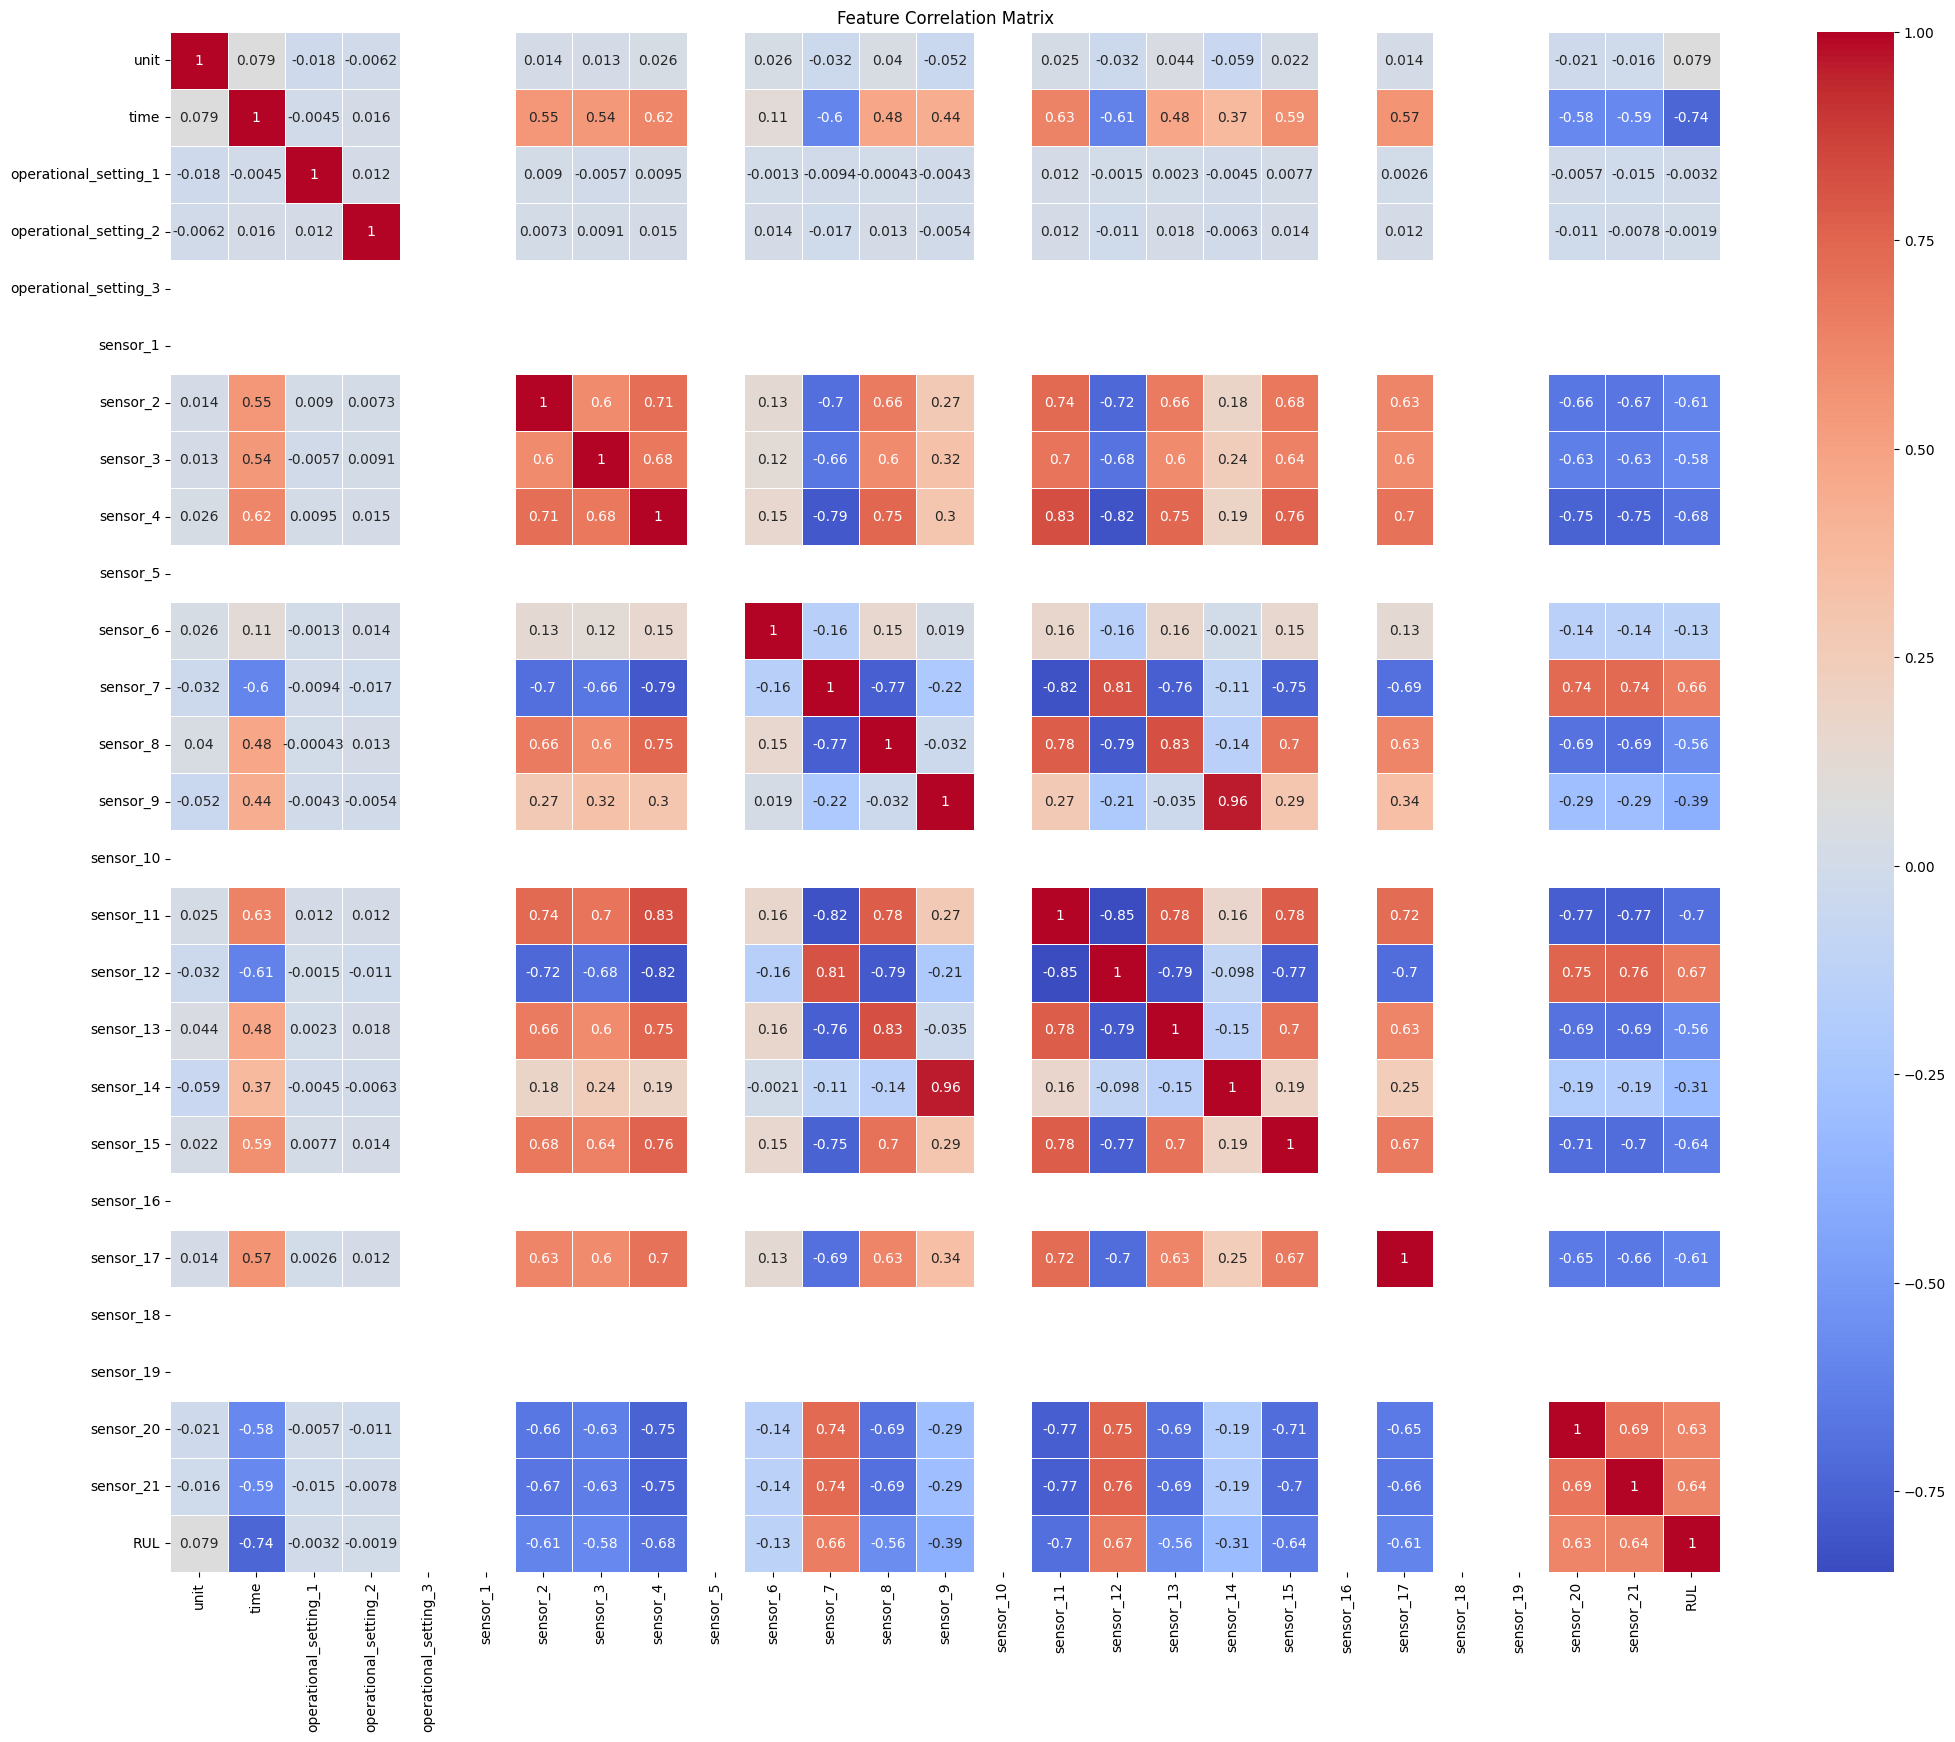

In [ ]:
# Feature correlation
plt.figure(figsize=(25, 20))
sns.heatmap(cmaps_data.corr(), annot=True, cmap="coolwarm", linewidths= 0.5)
plt.title("Feature Correlation Matrix")
plt.show()

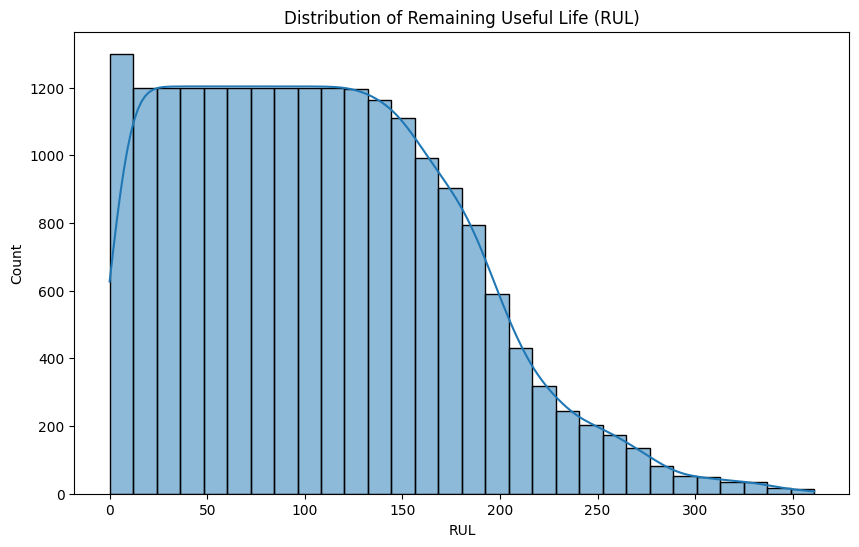

In [ ]:
# Visualizing RUL distribution
plt.figure(figsize=(10, 6))
sns.histplot(cmaps_data['RUL'], bins=30, kde=True)
plt.title("Distribution of Remaining Useful Life (RUL)")
plt.show()

In [ ]:
# Feature Selection
features = cmaps_data.columns[2:-1]  # Selecting all sensor data as features, excluding RUL
target = 'RUL'
X = cmaps_data[features]
y = cmaps_data[target]

# Train-Test Split
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
print("Normalizing feature data using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
print("Training models: Linear Regression and Random Forest...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    """Evaluates model performance using standard regression metrics."""
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R² Score: {r2_score(y_true, y_pred)}")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

print("Saving trained models...")
import joblib
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(lr, "linear_regression_model.pkl")

print("\nModel training and evaluation complete. Files saved.")

Splitting data into training and testing sets...
Normalizing feature data using StandardScaler...
Training models: Linear Regression and Random Forest...

Linear Regression Performance:
MAE: 34.050297279230946
MSE: 1966.2012639507052
RMSE: 44.34186807015132
R² Score: 0.569645560744755

Random Forest Performance:
MAE: 29.688841773685485
MSE: 1724.0290459655926
RMSE: 41.5214287563132
R² Score: 0.6226512682402188
Saving trained models...

Model training and evaluation complete. Files saved.


In [ ]:
# Data Health Check Script
# Step 1: Extract ZIP file
zip_path = "/content/archive.zip"  # Update this path if needed
extract_path = "/content/extracted_files"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Step 2: Locate training files
archive_folder_path = os.path.join(extract_path, "archive")
train_files = [f for f in os.listdir(archive_folder_path) if f.startswith("train_FD")]  # Select training files


# Step 3: Load a sample training file (modify if analyzing all files)
sample_file_path = os.path.join(archive_folder_path, train_files[0])


# Step 4: Read dataset with proper formatting
df = pd.read_csv(sample_file_path, delim_whitespace=True, header=None)

# Generate column names
df.columns = ["Engine_ID", "Cycle"] + [f"Feature_{i}" for i in range(1, df.shape[1] - 1)]

# Convert Engine_ID and Cycle to integers
df["Engine_ID"] = df["Engine_ID"].astype(int)
df["Cycle"] = df["Cycle"].astype(int)

<ipython-input-103-bada5dfd266a>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(sample_file_path, delim_whitespace=True, header=None)


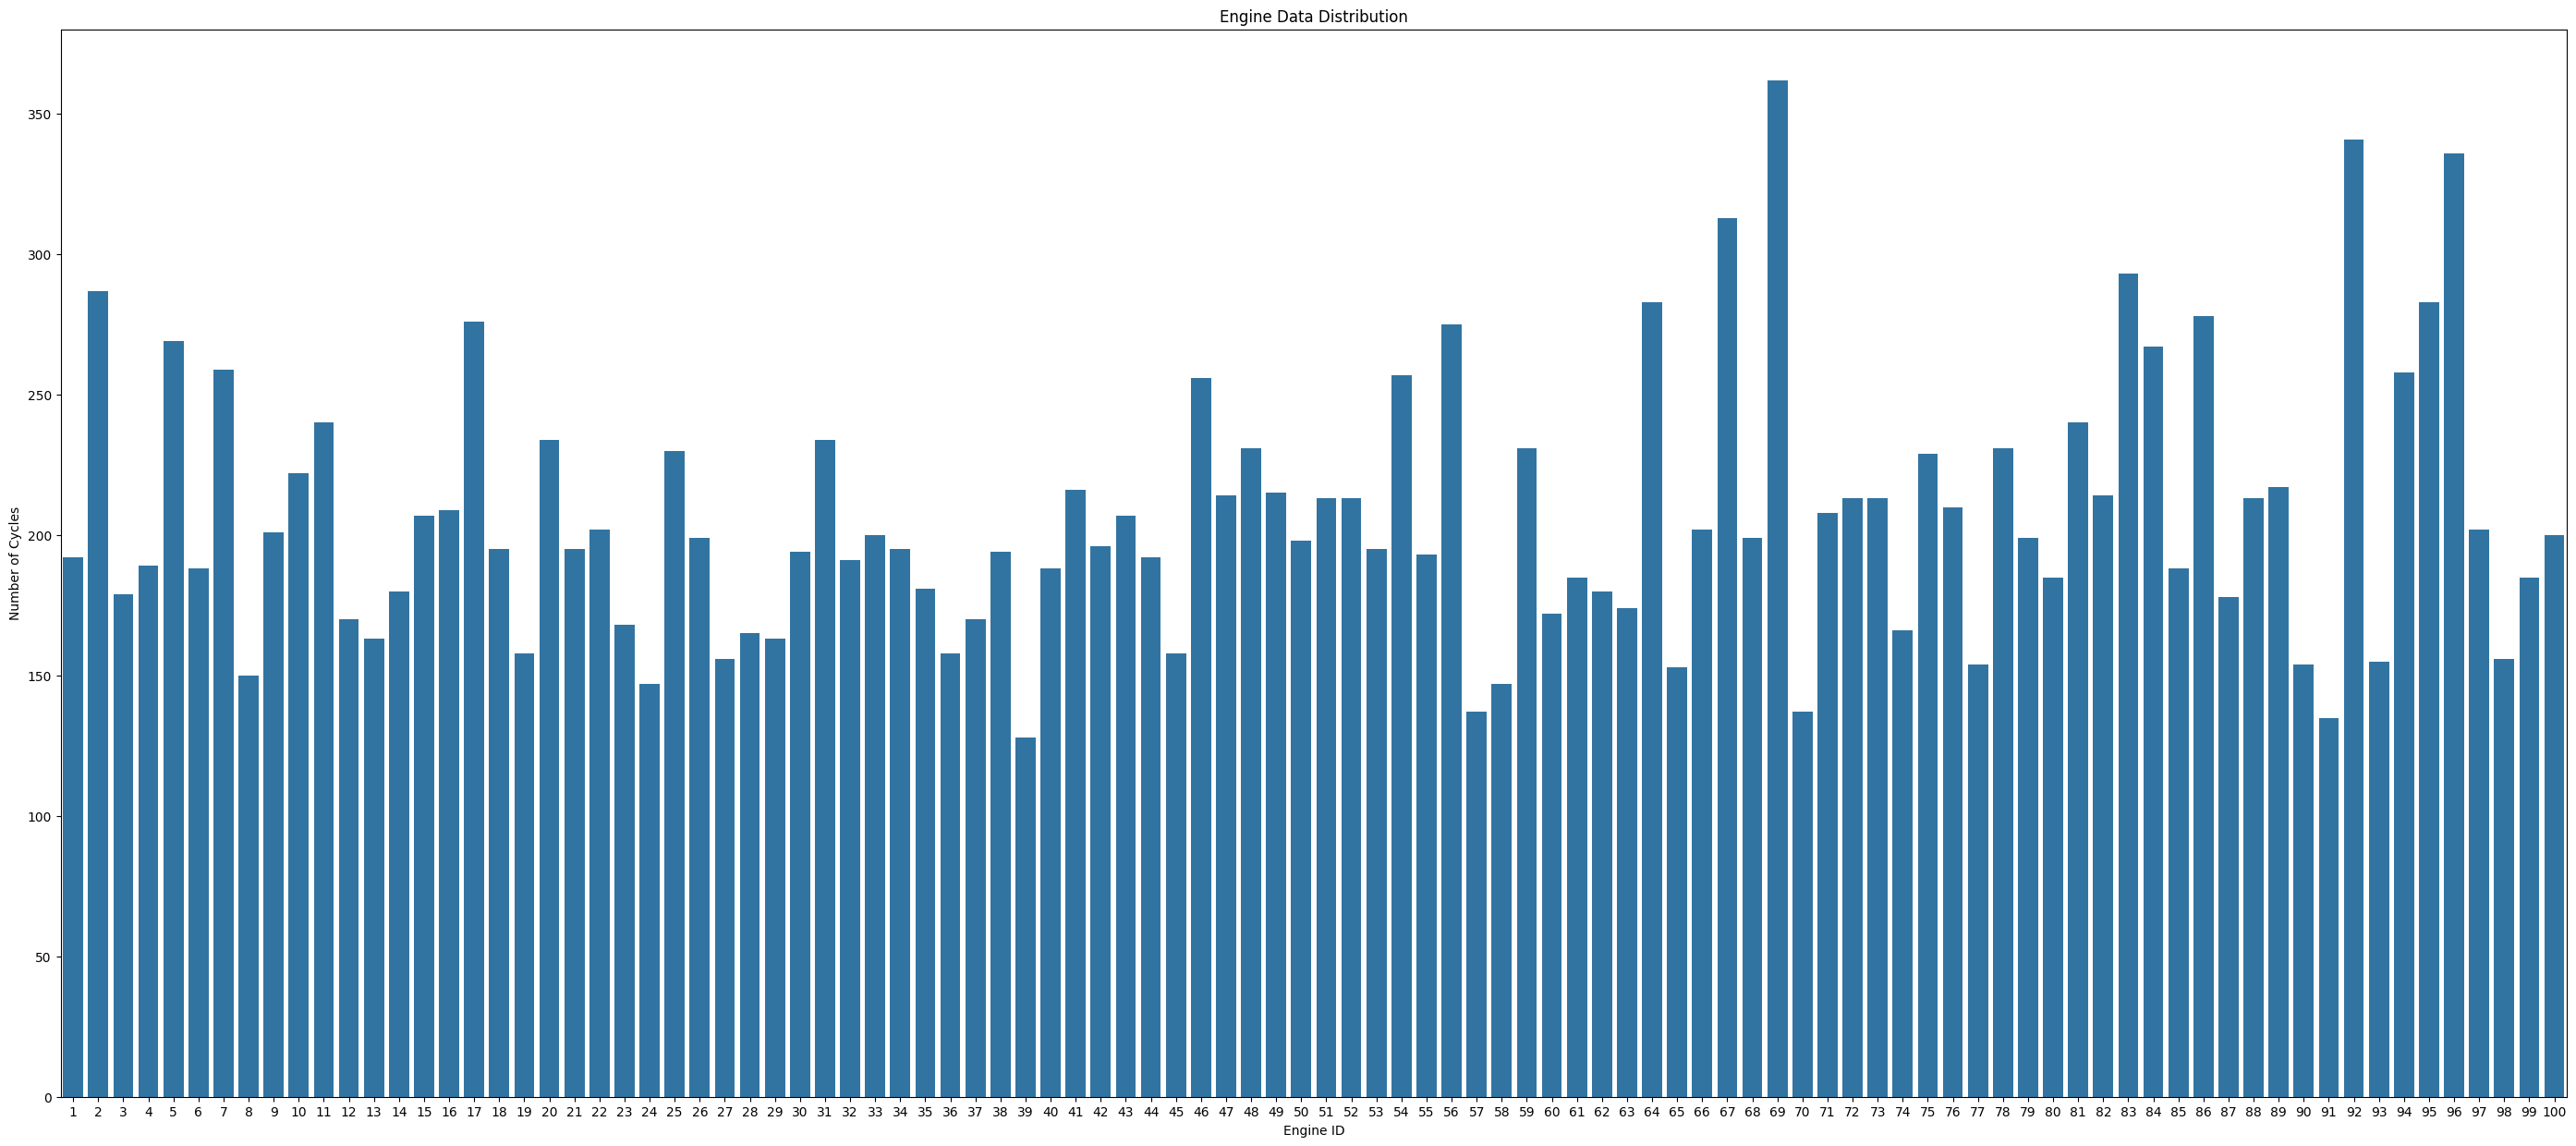

In [ ]:
# Step 5: Data Health Checks
## 1. Balance Check (Distribution of Engine IDs)
engine_counts = df["Engine_ID"].value_counts()
plt.figure(figsize=(35, 15))
sns.barplot(x=engine_counts.index, y=engine_counts.values)
plt.xlabel("Engine ID")
plt.ylabel("Number of Cycles")
plt.title("Engine Data Distribution")
plt.show()

In [ ]:
## 2. Range Check (Min-Max of Features)
feature_ranges = df.describe().loc[["min", "max"]]
print("Feature Ranges:\n", feature_ranges)

Feature Ranges:
      Engine_ID  Cycle  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
min        1.0    1.0    -0.0087    -0.0006      100.0     518.67     641.21   
max      100.0  362.0     0.0087     0.0006      100.0     518.67     644.53   

     Feature_6  Feature_7  Feature_8  ...  Feature_15  Feature_16  Feature_17  \
min    1571.04    1382.25      14.62  ...      518.69     2387.88     8099.94   
max    1616.91    1441.49      14.62  ...      523.38     2388.56     8293.72   

     Feature_18  Feature_19  Feature_20  Feature_21  Feature_22  Feature_23  \
min      8.3249        0.03       388.0      2388.0       100.0       38.14   
max      8.5848        0.03       400.0      2388.0       100.0       39.43   

     Feature_24  
min     22.8942  
max     23.6184  

[2 rows x 26 columns]


In [ ]:
## 3. Redundancy Check
### Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

### Check for high correlation
correlation_matrix = df.iloc[:, 2:].corr()
high_corr_features = (correlation_matrix.abs() > 0.95).sum().sum() - len(correlation_matrix)
print(f"Number of highly correlated feature pairs: {high_corr_features // 2}")

Number of duplicate rows: 0
Number of highly correlated feature pairs: -3


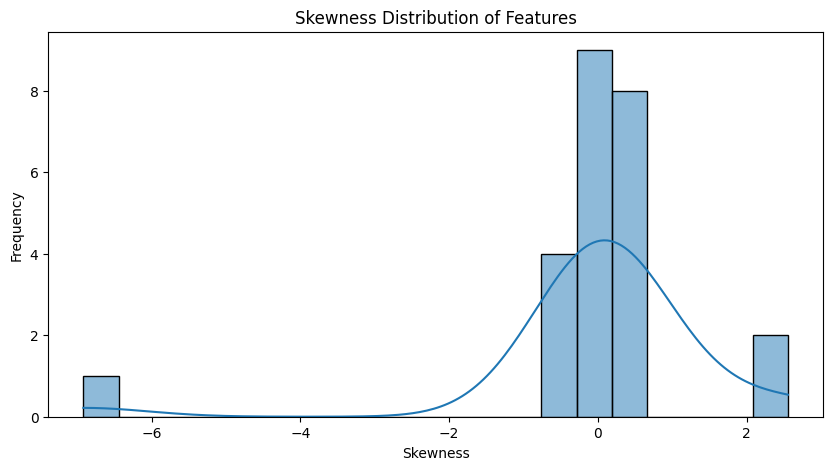

In [ ]:
## 4. Skewness Check
skewness = df.iloc[:, 2:].skew()
plt.figure(figsize=(10, 5))
sns.histplot(skewness, bins=20, kde=True)
plt.xlabel("Skewness")
plt.ylabel("Frequency")
plt.title("Skewness Distribution of Features")
plt.show()

In [ ]:
# Summary of Data Health
print("Data Health Summary:")
print("- Balanced Data:", "Yes" if engine_counts.std() < engine_counts.mean() * 0.1 else "No")
print("- Feature Values in Range:", "Yes" if (feature_ranges.loc["min"] >= -10).all() and (feature_ranges.loc["max"] <= 10000).all() else "Check Needed")
print("- Redundant Data:", "No Duplicates" if duplicate_rows == 0 else "Duplicates Found")
print("- Highly Correlated Features:", "No" if high_corr_features == 0 else "Check Needed")
print("- Skewed Data:", "No" if (abs(skewness) < 1).all() else "Yes, Transformation Recommended")

Data Health Summary:
- Balanced Data: No
- Feature Values in Range: Yes
- Redundant Data: No Duplicates
- Highly Correlated Features: Check Needed
- Skewed Data: Yes, Transformation Recommended
